## Import

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 32})
plt.rcParams["figure.figsize"] = (12,8)
import torch
import numpy as np
import scipy.signal
import scipy.io
import pandas as pd
import itertools
from itertools import product

from tqdm.notebook import tqdm, trange

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import random

In [ ]:
import h5py

## Data import

In [ ]:
FS = 50e3
fs =FS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset = h5py.File('/content/drive/MyDrive/dataset_.hdf5', 'r')

Mounted at /content/drive


In [ ]:
class H5Dataset:
    
    def __init__(self, h5dataset, segment_size = 1):
        self.dataset  = h5dataset
        self.ds_parts = list(self.dataset.keys())
        self.seg_size = int(segment_size)
        
    def visit(self):
        self.dataset.visit(lambda name: print(name))
    
            
    def inspect(self):
        for key in self.ds_parts:
            part = self.dataset[key]
            info = f'Name {key},\tType {type(part)}'
            info +=f' Shape {part.shape}, DType {part.dtype}'
            if isinstance(self.seg_size,int):
                info +=f' N segments {part.shape[1]//self.seg_size}'    
            print(info)
    
    def __len__(self):
        return self.length
    
    def get_source(self, part, source, label = None):
        if self.seg_size is None: raise ValueError
        
        source_data = self.dataset[part][source]
        
        segment = source_data.reshape(-1,self.seg_size)
        
        if label is None:
            label = source
        target  = label * np.ones(segment.shape[0])
        return segment, target

    def part(self, part_name):
        return self.dataset[part_name]
    
#     def get_batches_idxs 
    
    def get_range(self, part, sources = None, segments = None, label = None):
        if self.seg_size is None: raise ValueError
        
        data = self.dataset[part]
        if sources is None:  sources  = (0,data.shape[0])
        if segments is None: segments = (0,data.shape[1]//self.seg_size) 
        sources  = (max(0,int(sources[0])),min(data.shape[0],int(sources[1])))    
        segments = (segments[0]*self.seg_size,segments[1]*self.seg_size)  
        segments = (max(0,int(segments[0])),min(data.shape[1],int(segments[1])))

        return data[sources[0]:sources[1],segments[0]:segments[1] ]
        
    

In [ ]:
SEGMENT_SIZE = 10e3
SEGMENT_SIZE = int(SEGMENT_SIZE)

ds = H5Dataset(dataset, segment_size=SEGMENT_SIZE)
ds.inspect()

Name x_test_1,	Type <class 'h5py._hl.dataset.Dataset'> Shape (20, 12500000), DType float32 N segments 1250
Name x_test_2,	Type <class 'h5py._hl.dataset.Dataset'> Shape (20, 12500000), DType float32 N segments 1250
Name x_train_1,	Type <class 'h5py._hl.dataset.Dataset'> Shape (20, 12500000), DType float32 N segments 1250
Name x_train_2,	Type <class 'h5py._hl.dataset.Dataset'> Shape (20, 12500000), DType float32 N segments 1250


In [ ]:
part = ds.part('x_test_1')

In [ ]:
range_ = ds.get_range('x_test_1')
print(range_.shape)

(20, 12500000)


In [ ]:
range_ = ds.get_range('x_test_1',(0,2))
print(range_.shape)

(2, 12500000)


we have period about 1000 points

In [ ]:
x_,y_ = ds.get_source('x_test_1',0)

In [ ]:
lp = SEGMENT_SIZE

fs_half = lp//2
freqs_ = np.arange(lp//2)
# freqs_ = (fs*np.arange(lp)/lp)[:fs_half]
spx =(ut.afft(x_[0,:])[:fs_half])

shift_1 = 100
positions_1 = ut.findpeaks(spx[:shift_1], order=10, mode='maximum', min_distance=10, peak_threshold=1000,)

shift_2 = 500
positions_2 = ut.findpeaks(spx[shift_1:shift_2], order=10, mode='maximum', min_distance=10, peak_threshold=0,)

shift_3 = 1000
positions_3 = ut.findpeaks(spx[shift_2:shift_3], order=10, mode='maximum', min_distance=50, peak_threshold=0,)

shift_4 = 5000
positions_4 = ut.findpeaks(spx[shift_3:shift_4], order=100, mode='maximum', min_distance=100, peak_threshold=0,)

positions = np.concatenate((positions_1, positions_2+shift_1, positions_3+shift_2, positions_4+shift_3))
print(positions)

positions = np.concatenate(([0], positions, [5000] ))


[ 110  130  150  170  190  210  230  250  270  290  310  330  350  370
  390  410  430  450  470  490  500  560  620  690  750  810  870  930
 1020 1470 1790 2191 2504 2652 2791 2987 3121 3346 3669 3857 4031 4311
 4651 4777 4891]


[  10   30   50   70   90  100  130  151  170  190  210  231  290  310
  331  451  511 1001]


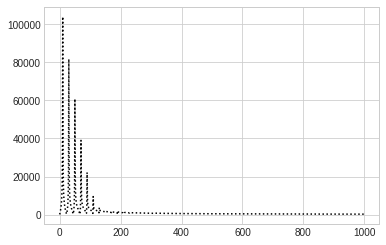

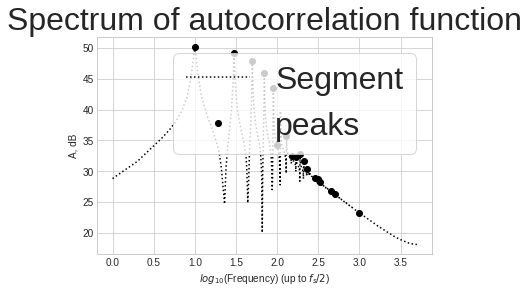

In [ ]:
fs = 50e3
lp = int(10e3)
fs_half = lp//2
freqs_ = np.arange(lp//2)
# freqs_ = (fs*np.arange(lp)/lp)[:fs_half]
spx =(ut.afft(ut.autocorrelation(x_[0,:]))[:fs_half])

shift_1 = 100
positions_1 = ut.findpeaks(spx[:shift_1], order=10, mode='maximum', min_distance=10, peak_threshold=1000,)

shift_2 = 500
positions_2 = ut.findpeaks(spx[shift_1:shift_2], order=10, mode='maximum', min_distance=10, peak_threshold=0,)

shift_3 = 1000
positions_3 = ut.findpeaks(spx[shift_2:shift_3], order=10, mode='maximum', min_distance=50, peak_threshold=0,)

shift_4 = 5000
positions_4 = ut.findpeaks(spx[shift_3:shift_4], order=100, mode='maximum', min_distance=100, peak_threshold=0,)

positions = np.concatenate((positions_1, positions_2+shift_1, positions_3+shift_2, positions_4+shift_3))
print(positions)

lfreqs = np.log10(freqs_)
logx   = 10*np.log10(spx)

plt.plot(freqs_[:1000], spx[:1000], linestyle=':', color = 'black', label='source 1-0');
# plt.plot(freqs_ [positions], logx[positions], 'o');
plt.show()

plt.plot(lfreqs, logx, linestyle=':', color = 'black', label='Segment');
plt.plot(lfreqs [positions], logx[positions], 'o', color = 'black', label='peaks');

plt.xlabel("$log_{10}$(Frequency) (up to $f_s/2$)")
plt.ylabel("A, dB")
plt.title('Spectrum of autocorrelation function', fontsize=32)
legend = plt.legend(ncol = 1, fontsize = 32, frameon = 1)
# frame = legend.get_frame()
# frame.set_color('white')
plt.savefig('typical_signal_spectrum-autocor-peaks.pdf', dpi=120, format='pdf', bbox_inches='tight')

plt.show()

positions = np.concatenate(([0], positions, [5000] ))


In [ ]:
np.array(fs*positions/10e3).astype(int), np.array(fs*positions/10e3).size

(array([    0,    50,   150,   250,   350,   450,   500,   650,   755,
          850,   950,  1050,  1155,  1450,  1550,  1655,  2255,  2555,
         5005, 25000]), 20)

In [ ]:
def autocor(x, n_fft = None, deivce = 'cpu'):
    if n_fft is None: n_fft =  2*x.shape[1]
    x   = torch.atleast_2d(torch.as_tensor(x)).to(device) 
    sp  = torch.fft.fft(x, n =n_fft, dim = -1).to(device)  
    sp  = (sp*sp.conj()).real     
    return torch.fft.ifft(sp, n =n_fft, dim = -1)[:,:n_fft//2].real.to(device)  

def hilbert(x, n_fft = None, deivce = 'cpu'):
    if n_fft is None: n_fft =  x.shape[1]
    x   = torch.atleast_2d(torch.as_tensor(x)).to(device) 
    sp  = torch.fft.fft(x, n =n_fft, dim = -1).to(device)   
    sp[n_fft//2:] = 0    
    return torch.fft.ifft(sp, n =n_fft, dim = -1)

def square_filter(x, fp, lp, real_val = True, device = 'cpu'):
    x     = torch.atleast_2d(torch.as_tensor(x).to(device))
    n_fft =  x.shape[1]
    sp    = torch.fft.fft(x, n =n_fft, dim = -1).to(device)  

    sp    = _square_filter_(sp, fp, lp, n_fft, real_val = True)
    out   = torch.fft.ifft(sp, n =n_fft, dim = -1).to(device)

    if real_val: out = out.real
    return out

def _square_filter_(sp, fp, lp, n_fft, real_val = True):
    sp[:,:fp] = 0
    sp[:,lp:n_fft//2] = 0
    if real_val:
        sp[:,n_fft - fp +1:] = 0    
        sp[:,n_fft//2:n_fft//2+(n_fft//2-lp) +1 ] = 0
    else:
        sp[:,n_fft//2:] = 0
    return sp

# def transform(x, fp, lp):
#     n_fft =  2*x.shape[1]
#     x     = torch.atleast_2d(torch.as_tensor(x))
#     sp    = torch.fft.fft(x, n =n_fft, dim = -1) 
#     sp    = _square_filter_(sp, fp, lp, n_fft, real_val = True)
#     sp    = (sp*sp.conj()).real     
#     return torch.fft.ifft(sp, n =n_fft, dim = -1)[:,:x.shape[1]].real 

def transform(x, fp, lp, device = 'cpu'):    
    return square_filter(x, fp, lp, real_val = True, device = device)

def barycenter_frequency(x, fs = None, n_fft = None, sp_square = False , device = 'cpu'):
    x = torch.as_tensor(x).to(device)
    
    if n_fft is None:
        n_fft = x.shape[-1]
    
    sp = torch.fft.fft(x,n = n_fft, dim = -1)[:,:n_fft//2]
    sp.to(device)

    if fs is None: fs = 1
    
    if sp_square:
        sp = (sp*sp)
    else:
        sp = sp.abs()

    w_band = torch.tensor([0,n_fft//2]).type(torch.IntTensor).to(device)
    n = fs*torch.range(w_band[0], w_band[1]-1)/n_fft
    n.to(device)
    torch.sum(n.to(device)*sp.to(device), dim = -1)

    return torch.sum(n.to(device)*sp.to(device), dim = -1)/torch.sum(sp.to(device), dim = -1)

def ar_burg(x, order, device = 'cpu'):    
    x   = torch.atleast_2d(torch.as_tensor(x).to(device))
    N = x.shape[-1]
    a  = torch.zeros((x.shape[0],order)).type(torch.float).to(device)
    k  = torch.zeros((x.shape[0],order)).type(torch.float).to(device) #need only for variance
    
    ef = x.clone().type(torch.float).to(device)
    eb = x.clone().type(torch.float).to(device)
    
    for i in range(order):
        
        #TODO: eluminate k (reduce array)
        efp = ef[:,i+1:]
        ebp = eb[:,i:-1]
        
        num  = torch.sum(efp*ebp.conj(), dim = -1)        
        den  = torch.sum(ebp*ebp.conj(), dim = -1)
        den += torch.sum(efp*efp.conj(), dim = -1)
        k[:,i] = -2*num/den 
       
        a[:,i] = k[:,i].clone()
        if i > 0: 
            a[:,:i] = a[:,:i]+ ( k[:,i]*a[:,:i].flip(-1).conj().t() ).t()

        tmp1 = ef[:,i+1:] + ( k[:,i]*eb[:,i:-1].t() ).t()
        tmp2 = eb[:,i:-1] + ( k[:,i].conj()*ef[:,i+1:].t() ).t()
        ef[:,i+1:] = tmp1.clone()
        eb[:,i+1:] = tmp2.clone()
    
    a = torch.column_stack([torch.ones(x.shape[0]).to(device),a[:,:]]).to(device)    

    var = torch.sum(x*x.conj(), dim = -1)/N
    for i in range(order):
        var = var*(1-k[:,i]*k[:,i].conj())
                   
    return a, var

def stat_moments(x, device = 'cpu'):
    x     = torch.atleast_2d(torch.as_tensor(x))
    mean  = x.mean(-1)
    diffs = (x.t() - mean).t()
    std   = x.std(-1)
    zscores = (diffs.t() / std).t()
    skews = torch.mean(torch.pow(zscores, 3.0), dim = -1)
    kurtoses = torch.mean(torch.pow(zscores, 4.0), dim = -1) - 3.0 
    return mean, std, skews, kurtoses

def to_np_classes(X, n_classes = 40):
    n_signals = X.shape[0]//n_classes
    return X.view(-1,n_signals).data.cpu().numpy()

def to_np(x):
    return x.data.cpu().numpy()

def ecdf(x):
    x    = torch.atleast_2d(torch.as_tensor(x))
    bins = torch.sort(x,dim = -1, descending = False)[0]
    ecdf = torch.linspace(0,1,x.shape[1]) 
    ecdf = ecdf.repeat(bins.shape[0]).view(bins.shape[0],-1)
    return bins, ecdf

def maxcorfreq_real(s,with_xcorr=False, device = 'cpu'): 

    s = torch.as_tensor(s).to(device)
    
    if with_xcorr:        
        s  = autocor(s)
        
    s1 = s[:,1:]
    s2 = s[:,:-1]

    corcof = torch.sum(s1*s2, dim = -1)/torch.sum(torch.square(s), dim = -1)
    angle = torch.arccos(corcof) 
    return angle#fs*angle/(2*np.pi)

def maxcorfreq_complex(s,with_xcorr=False, device = 'cpu'): 

    s = torch.as_tensor(s).to(device)

    if with_xcorr:        
        s  = autocor(s)
    
    s = hilbert(s)
        
    s1 = s[:,1:]
    s2 = s[:,:-1]

    corcof = torch.sum(s1*s2, dim = -1)#/torch.sum(torch.square(s), dim = -1)
    angle = torch.angle(corcof) 
    return angle#fs*angle/(2*np.pi)

In [ ]:
def feature_extractor(signals, limits = None,  device = 'cpu'):
    
    signals = torch.as_tensor(signals).to(device)
    df = pd.DataFrame()
    
    if limits is None:
        limits = [0,signals.shape[1]//2]
        
    limits = np.atleast_2d(np.asarray(limits,dtype = int))
   
    for i,limi in enumerate(limits):

        signals_ = transform(signals.clone(), *limi, device=device)
        
        df_      = _feature_extractor_(signals_, device=device)
        
        df_.columns = [col+str(i) for col in df_.columns.values]
        df = pd.concat([df,df_],axis=1)
        
#         signals_ = autocor(signals_[:,:] )
#         df_      = _feature_extractor_(autocor(signals_[:,:] ))
#         df_      = _feature_extractor_(signals_[:,1000:] - signals_[:,:-1000])
        
#         df_.columns = [col+'dif'+str(i) for col in df_.columns.values]
#         df = pd.concat([df,df_],axis=1)        

    # df['source'] =  np.asarray(targets, dtype= int)

    return df

def _feature_extractor_(X, device = 'cpu'):

    mean, std, skews, kurtoses = stat_moments(X.abs(), device=device)
    
    kurtoses_abs = to_np(kurtoses)
    mean_abs     = to_np(mean)
    std_abs      = to_np(std)
    skews_abs    = to_np(skews)
    
    mean, std, skews, kurtoses = stat_moments(X, device=device)
    
    kurtoses = to_np(kurtoses)
    mean     = to_np(mean)
    std      = to_np(std)
    skews    = to_np(skews)    
    
    median   = torch.median(torch.unique(X.abs(),dim = -1), dim=-1).values
    median_abs = to_np(median)
    
    median   = torch.median(torch.unique(X,dim = -1), dim=-1).values
    median   = to_np(median)    
    
    maxcorfreq = to_np(maxcorfreq_real(X, device))
    barycenter_freq = to_np(barycenter_frequency(X,sp_square=True, device=device))
    
    a, var = ar_burg(X, order=1, device=device)
    ar_freq = to_np(a[:,1])
    ar_var  = to_np(var)
    
    df = pd.DataFrame({
        'mean_abs': mean_abs,
        'std_abs': std_abs,
        'kurtoses_abs':kurtoses_abs,
        'skews_abs':skews_abs,
        'median_abs': median_abs,
        'mean': mean,
        'std': std,
        'kurtoses':kurtoses,
        'skews':skews,
        'median': median,        
        'barycenter_freq':barycenter_freq,
        'ar_freq': ar_freq,
        'maxcorfreq': maxcorfreq,
        'ar_var': ar_var,
    })
    return df



In [ ]:
FP,LP = positions[:-1],positions[1:]
FP = np.concatenate([positions[:-x] for x in range (1,20)])
LP = np.concatenate([positions[x: ] for x in range (1,20)])
limits = np.column_stack((FP,LP))
limits, limits.shape
np.unique(limits, axis =1)

array([[   0,   10],
       [  10,   30],
       [  30,   50],
       [  50,   70],
       [  70,   90],
       [  90,  100],
       [ 100,  130],
       [ 130,  151],
       [ 151,  170],
       [ 170,  190],
       [ 190,  210],
       [ 210,  231],
       [ 231,  290],
       [ 290,  310],
       [ 310,  331],
       [ 331,  451],
       [ 451,  511],
       [ 511, 1001],
       [1001, 5000],
       [   0,   30],
       [  10,   50],
       [  30,   70],
       [  50,   90],
       [  70,  100],
       [  90,  130],
       [ 100,  151],
       [ 130,  170],
       [ 151,  190],
       [ 170,  210],
       [ 190,  231],
       [ 210,  290],
       [ 231,  310],
       [ 290,  331],
       [ 310,  451],
       [ 331,  511],
       [ 451, 1001],
       [ 511, 5000],
       [   0,   50],
       [  10,   70],
       [  30,   90],
       [  50,  100],
       [  70,  130],
       [  90,  151],
       [ 100,  170],
       [ 130,  190],
       [ 151,  210],
       [ 170,  231],
       [ 190,

In [ ]:
CLASSES_PER_PART = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_features(ds, parts, limits, device = 'cpu'):
    parts = sum([],parts)
    df = pd.DataFrame([])    
    for  (cntpart,part),i in tqdm( product(enumerate(parts), range(CLASSES_PER_PART)  ) ):

        x_,y_ = ds.get_source(part,i)
        
        df_ = feature_extractor(x_, limits = limits,  device = device)
        
        df = pd.concat([df,df_ ],axis=0, ignore_index=True)
    
#         df.to_json('EWT_features_storage_full_x1.json',orient='table')
    return df


In [ ]:
df_train = get_features(ds, ['x_train_1','x_train_2'], limits = limits, device= device)
df_test  = get_features(ds, ['x_test_1',  'x_test_2'], limits = limits, device= device)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
df_train.sample(10)

,mean_abs0,std_abs0,kurtoses_abs0,skews_abs0,median_abs0,mean0,std0,kurtoses0,skews0,median0,...,median_abs189,mean189,std189,kurtoses189,skews189,median189,barycenter_freq189,ar_freq189,maxcorfreq189,ar_var189
38555,1.952732,1.344842,1.588478,1.202361,1.819034,0.013341,2.371068,-0.033761,0.011989,0.011036,...,1.053134,0.013341,11.030676,10.000485,0.061559,-0.022229,0.002712-0.001433j,-0.999672,0.056254,0.079900
41373,1.990840,1.377006,1.612464,1.214663,1.848783,0.012023,2.420711,-0.011390,0.011703,0.011276,...,1.110934,0.012023,11.131890,9.467569,0.055641,0.016139,0.002506-0.001310j,-0.999699,0.055062,0.074681
23665,6.568706,4.526447,1.613573,1.208743,6.121866,0.010860,7.977520,-0.025470,0.012137,0.000966,...,1.947209,0.010860,35.782692,8.823071,0.036688,-0.054712,0.002500-0.001414j,-0.999734,0.053852,0.680000
41834,1.932172,1.331339,1.633682,1.213461,1.802744,0.003143,2.346511,-0.020783,0.013113,0.002225,...,1.056463,0.003143,10.687593,8.816702,0.033174,0.025767,0.002340-0.001181j,-0.999730,0.053724,0.061779
41253,1.977529,1.370279,1.627278,1.221130,1.836225,0.014493,2.405924,-0.000713,0.012019,0.012907,...,1.110773,0.014493,11.220993,9.740443,0.061932,0.010402,0.002612-0.001491j,-0.999684,0.055729,0.079664
49784,2.848288,1.970687,1.662376,1.226637,2.653514,0.005317,3.463689,0.002150,0.012001,0.000968,...,1.652661,0.005317,15.812926,8.755410,0.032308,0.006675,0.002255-0.000927j,-0.999732,0.053091,0.133989
18448,2.341025,1.622402,1.640771,1.224344,2.174459,0.012608,2.848329,0.003166,0.012876,0.007727,...,0.993599,0.012608,13.118357,8.629391,0.053243,0.010474,0.002295-0.001063j,-0.999736,0.053496,0.090677
47117,4.184036,2.901370,1.641427,1.224679,3.877803,0.006470,5.091740,0.005327,0.011038,0.000301,...,1.687168,0.006470,23.479107,8.349800,0.033047,-0.048425,0.002272-0.000902j,-0.999749,0.053168,0.276277
26692,3.521303,2.450660,1.672722,1.237991,3.262631,0.008688,4.290277,0.027335,0.012605,0.003725,...,2.199624,0.008688,19.492573,10.461819,0.130698,-0.066892,0.002420-0.001089j,-0.999653,0.053465,0.263907
31069,3.627001,2.543479,1.761929,1.270621,3.355282,0.025899,4.430018,0.079512,0.013351,0.024923,...,0.293071,0.025899,23.088484,10.114990,0.052104,-0.005698,0.002514-0.000571j,-0.999656,0.059283,0.366699


In [ ]:
df_test.sample(10)

,mean_abs0,std_abs0,kurtoses_abs0,skews_abs0,median_abs0,mean0,std0,kurtoses0,skews0,median0,...,median_abs189,mean189,std189,kurtoses189,skews189,median189,barycenter_freq189,ar_freq189,maxcorfreq189,ar_var189
22333,5.382797,3.707675,1.621715,1.209892,5.023190,0.008084,6.536375,-0.025149,0.011376,-0.001161,...,1.912861,0.008084,28.876337,8.502779,0.044415,-0.066893,0.002400-0.001399j,-0.999748,0.052501,0.420974
27519,5.230292,3.642545,1.691402,1.243440,4.847432,0.043976,6.373766,0.034471,0.012022,0.035922,...,2.437944,0.043976,30.580524,9.714568,0.081502,0.043201,0.002107-0.000502j,-0.999687,0.055568,0.584882
19319,7.865788,5.442550,1.642613,1.222024,7.316720,0.028436,9.565425,-0.002586,0.010140,0.010383,...,2.170011,0.028436,43.067131,7.669920,0.041541,0.007166,0.002104-0.000961j,-0.999779,0.051388,0.821440
3326,6.014502,4.196019,1.691988,1.246063,5.564185,0.009072,7.333781,0.041601,0.010182,0.001209,...,1.748679,0.009072,33.384941,7.403279,0.030087,0.014016,0.001830-0.000480j,-0.999792,0.050744,0.463055
44530,2.317715,1.612679,1.674522,1.238848,2.147410,0.013207,2.823632,0.027302,0.012307,0.009814,...,1.118803,0.013207,13.389907,9.400181,0.057687,-0.041626,0.002443-0.000835j,-0.999699,0.055449,0.107795
2409,4.751132,3.283013,1.646574,1.220978,4.424827,0.006466,5.775262,-0.006648,0.009925,0.002773,...,1.493394,0.006466,25.586088,7.351472,0.026962,0.023349,0.002043-0.000985j,-0.999794,0.050535,0.269172
10955,5.951664,4.130769,1.662773,1.231385,5.523362,0.009496,7.244930,0.014261,0.009498,0.001509,...,1.606432,0.009496,31.729155,6.676972,0.027414,0.006945,0.001895-0.000790j,-0.999819,0.049115,0.365342
29637,4.053140,2.818640,1.653128,1.231507,3.749689,0.015887,4.937010,0.018994,0.011482,0.007417,...,3.286412,0.015888,22.232111,9.065097,0.053988,-0.097201,0.002019-0.000441j,-0.999716,0.052091,0.280290
3881,5.604162,3.876265,1.633544,1.219525,5.212193,0.007686,6.814333,-0.006028,0.009874,-0.003925,...,1.437019,0.007686,30.529644,7.443135,0.029580,0.021074,0.002067-0.000954j,-0.999790,0.051034,0.390457
8776,6.089599,4.233251,1.666520,1.234633,5.644782,0.011364,7.416684,0.021313,0.010078,0.005012,...,1.675752,0.011364,33.384220,7.322263,0.032454,0.005431,0.001947-0.000686j,-0.999795,0.050603,0.457854


In [ ]:
df_train.to_json('/content/drive/MyDrive/EWT_features_train_aftx.json',orient='values', force_ascii=False)
df_test.to_json( '/content/drive/MyDrive/EWT_features_test_aftx.json', orient='values', force_ascii=False)

In [ ]:
dfcolumns = pd.DataFrame([df_test.columns]).to_csv('/content/drive/MyDrive/columns.csv')

In [ ]:
df_tt = pd.read_json('/content/drive/MyDrive/EWT_features_test_aftx.json',orient='values')